In [1]:
import scipy.cluster.vq as scv
from PIL import Image
from numpy import array
import numpy as np
from scipy import misc

import pandas as pd
import geopandas as gpd
import statsmodels.formula.api as smf
import itertools
from shapely.geometry import Point, Polygon, LineString

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
# ignore warings of notebook

### 导入原始分析数据数据

In [2]:
# 地理信息格网数据
grid_gdf = gpd.read_file('../../202203_Campus/03_data/05_28/0425_tsinghua_sample.shp')
# 清华边界数据
thu_gdf = gpd.read_file('../../202203_Campus/03_data/GIS/tsinghua.shp')
# 0516-0522这些天的数据(一周周六到周日)
keep_gdf = gpd.GeoDataFrame(data = None, columns = gpd.read_file('../../202204_keepdata/03_data/keep_data/keep_05_16' + '/new_keep_gdf_all.shp').columns)
gdf_list = []
for i in [16,17,18,19,20,21,22]:
    gdf_list.append(gpd.read_file('../../202204_keepdata/03_data/keep_data/keep_05_'+ str(i) +'/new_keep_gdf_all.shp'))
keep_gdf = keep_gdf.append(gdf_list)
keep_gdf = keep_gdf.reset_index(drop=True)

campus_columns = ['built_area','num_bldg','building_a','OSM_area','other_tags','landuse_ar','leisure_ar','natural_ar','tourism_ar','amenity_ar','sport_area','place_area','shop_area','office_are','barrier_ar','man_made_a']

In [3]:
# gdf_list = []
# for i in ['24_2',25,26,27,28,29]:
#     gdf_list.append(gpd.read_file('../../202204_keepdata/03_data/keep_data/keep_04_'+ str(i) +'/new_keep_gdf_all.shp'))
# keep_gdf = keep_gdf.append(gdf_list)
# keep_gdf = keep_gdf.reset_index(drop=True)

In [4]:
keep_gdf.shape

(159236, 5)

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
standardScaler = StandardScaler()

In [7]:
# 标准化数据 grid_copy
num_feature = standardScaler.fit_transform(grid_gdf[campus_columns])
grid_copy = grid_gdf
grid_copy[campus_columns] = num_feature
grid_copy[1500:1501]

,built_area,num_bldg,building_a,OSM_area,other_tags,landuse_ar,leisure_ar,natural_ar,tourism_ar,amenity_ar,...,office_are,barrier_ar,man_made_a,keep_lengt,length_ave,keep_num,speed,roadname,roaddist,geometry
1500,5.057671,0.862264,0.209606,1.140752,1.137474,0.358002,0.445446,-0.202681,-0.101172,-0.326731,...,15.247371,-0.101153,-0.048643,0.0,0.0,0.0,0.0,pedestrian,0.00001,"POLYGON ((116.31596 40.00133, 116.31596 40.001..."


### 一些笔记

面板数据构建
描述性统计

面板单位根检验 检验数据是否平稳——平稳进入模型——不平稳协整分析
固定系数 随机系数
固定系数分为长面板和短面板 LM LLC Fisher IPS（少数服从多数，以PPFisher为主）。短面板 HT HL

平稳的话 进入平稳面板数据模型

不平稳 差分变换到平稳面板数据 或协整检验
拒绝H0则存在回归 如果不拒绝H0则证明为伪回归

平稳面板数据模型 变截距

1 个体效应

2 时间效应

3 Hausman检验

### 数据情况概览与清洗

In [8]:
# 接下来整合清华范围的格网和keep数据进行分析
keep_gdf.crs = 'epsg:4326'
thu = gpd.read_file('../../202203_Campus/03_data/GIS/tsinghua.shp')
thu.crs = 'epsg:4326'
df_clean_clear = keep_gdf.to_crs('epsg:4326')
sjoin_intersects = gpd.sjoin(keep_gdf, thu, op='within')

In [9]:
sjoin_intersects.shape

(1247, 32)

In [10]:
grid_gdf[1500:1501]

,built_area,num_bldg,building_a,OSM_area,other_tags,landuse_ar,leisure_ar,natural_ar,tourism_ar,amenity_ar,...,office_are,barrier_ar,man_made_a,keep_lengt,length_ave,keep_num,speed,roadname,roaddist,geometry
1500,5.057671,0.862264,0.209606,1.140752,1.137474,0.358002,0.445446,-0.202681,-0.101172,-0.326731,...,15.247371,-0.101153,-0.048643,0.0,0.0,0.0,0.0,pedestrian,0.00001,"POLYGON ((116.31596 40.00133, 116.31596 40.001..."


In [11]:
df = sjoin_intersects

for i in df.index:
    start_point = df.loc[i].geometry.coords[0]
    df.loc[i, 'start_latitude'] = start_point[1]
    df.loc[i, 'start_longitude'] = start_point[0]
    
    end_point = df.loc[i].geometry.coords[-1]
    df.loc[i, 'end_latitude'] = end_point[1]
    df.loc[i, 'end_longitude'] = end_point[0]

# crs change
df.crs = 'epsg:4326'
df_copy = df.to_crs('epsg:4509')
df_copy.length.head()

df['start_date'] = df['start_time'].str.split('_').str[0]
df['start_time_time'] = df['start_time'].str[3:].str.replace('_',":")

df['end_date'] = df['end_time'].str.split('_').str[0]
df['end_time_time'] = df['end_time'].str[3:].str.replace('_',":")

df['start_date'] = '2022/05/'+df['start_date']
df['end_date'] = '2022/05/'+df['end_date']

df['start_datetime'] = pd.to_datetime(df['start_date'] + ' ' + df['start_time_time'])
df['end_datetime'] = pd.to_datetime(df['end_date'] + ' ' + df['end_time_time'])

df['duration'] = df['end_datetime']-df['start_datetime']


df = df[['start_datetime', 'end_datetime', 'start', 'end', 'geometry', 'duration',
         'start_latitude','start_longitude','end_latitude','end_longitude']]


df['duration_minutes'] = df.index.map(lambda i: divmod(df['duration'][i].total_seconds(), 60)[0] )

Text(0, 0.5, 'Sample Density')

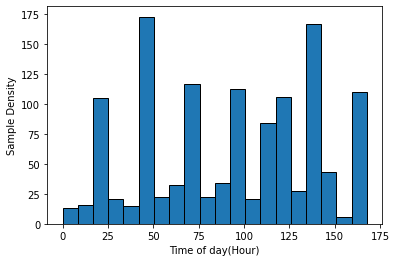

In [12]:
# clean 
df_clean = df
df_clean_copy = df_clean.to_crs('epsg:4509')

def pair(list):
    for i in range(1, len(list)):
        yield list[i-1],list[i]
        
max_list = []
df_count = 0
for i in df_clean_copy.geometry:
    test_list = list(i.coords)
    a_float = []
    k = 0
    for pt1,pt2 in pair(test_list):
        a_float.append(LineString([pt1,pt2]).length)
        k = k + 1
    df_clean_copy.loc[df_count,'max_length'] = max(a_float)
    df_clean_copy.loc[df_count,'count_time'] = k
    max_list.append(max(a_float))
    df_count = df_count + 1
df_clean_copy['max_speed'] = df_clean_copy['max_length'] * df_clean_copy['count_time'] / df_clean_copy['duration_minutes']

df_clean_copy_clear = df_clean_copy.drop(df_clean_copy[df_clean_copy['max_speed']>745].index)
df_clean_clear = df_clean_copy_clear.to_crs('epsg:4509')

keep_gdf_clean = df_clean_copy_clear.to_crs('epsg:4326')

keep_gdf_clean['starttime_hour'] = (keep_gdf_clean.start - keep_gdf_clean.start.min()) / 3600
keep_gdf_clean.starttime_hour.hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('Time of day(Hour)')
plt.ylabel('Sample Density')

<AxesSubplot:>

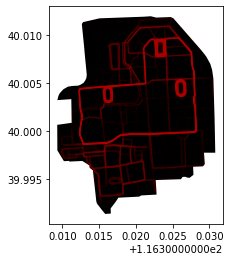

In [13]:
ax = thu_gdf.plot(color = 'black')
keep_gdf_clean.plot(ax =ax,color = 'r',alpha = 0.01)

In [14]:
keep_gdf_clean.shape

(2488, 15)

In [15]:
keep_gdf_clean.head(1)

,start_datetime,end_datetime,start,end,geometry,duration,start_latitude,start_longitude,end_latitude,end_longitude,duration_minutes,max_length,count_time,max_speed,starttime_hour
58,2022-05-16 21:51:10,2022-05-16 22:54:06,1461070,1464846,"LINESTRING (116.32259 39.99572, 116.32254 39.9...",0 days 01:02:56,39.995724,116.322593,39.996297,116.326205,62.0,70.927441,153.0,175.030621,21.802222


### 尝试描述清华路段的OD关系和时间

In [16]:
keep_gdf_clean.dropna(subset = ['start'],inplace = True)

In [17]:
gdf_copy_0619 = keep_gdf_clean

In [18]:
gdf_copy_0619['OD_length'] = (gdf_copy_0619['start_latitude'] - gdf_copy_0619['end_latitude'])** 2 + (gdf_copy_0619['start_longitude'] - gdf_copy_0619['end_longitude'])**2 

In [19]:
gdf_copy_0619['start_time_hour'] = gdf_copy_0619.index.map(lambda i: gdf_copy_0619['start_datetime'][i].hour)

In [20]:
gdf_copy_0619.groupby('start_time_hour')['OD_length'].describe() 

,count,mean,std,min,25%,50%,75%,max
start_time_hour,,,,,,,,
0,120.0,8.862416e-06,2.363868e-05,1.599859e-09,2.157816e-07,1.480147e-06,4.559363e-06,1.615858e-04
5,8.0,1.001891e-05,1.199778e-05,1.102731e-07,4.350680e-07,6.749049e-06,1.326766e-05,2.952670e-05
6,30.0,7.747289e-06,2.816474e-05,9.990268e-09,1.000695e-07,3.714756e-07,2.528602e-06,1.548276e-04
7,59.0,7.331438e-06,1.460562e-05,1.701041e-09,6.418800e-07,1.829116e-06,6.625558e-06,6.577896e-05
8,22.0,1.004251e-05,3.585735e-05,9.982464e-10,2.746392e-08,5.200011e-07,1.765223e-06,1.690881e-04
9,20.0,8.171482e-06,9.768840e-06,1.998497e-08,8.603717e-07,3.394285e-06,1.149338e-05,2.789160e-05
10,6.0,1.955763e-06,1.764744e-06,9.617834e-08,6.923101e-07,1.621922e-06,2.793065e-06,4.828673e-06
11,4.0,1.239084e-06,9.488253e-07,2.073092e-08,7.345282e-07,1.403910e-06,1.908466e-06,2.127787e-06
12,5.0,8.671509e-07,6.637547e-07,5.298543e-08,2.605894e-07,1.145335e-06,1.411867e-06,1.464978e-06


In [21]:
gdf_copy_0619[gdf_copy_0619['start_time_hour']<=12]['geometry']

93        LINESTRING (116.31371 39.99840, 116.31359 39.9...
1776      LINESTRING (116.31211 39.99756, 116.31262 39.9...
2184      LINESTRING (116.32388 40.00932, 116.32396 40.0...
3855      LINESTRING (116.32365 40.00783, 116.32352 40.0...
4004      LINESTRING (116.32363 40.00779, 116.32390 40.0...
                                ...                        
154982    LINESTRING (116.32270 40.00838, 116.32269 40.0...
155077    LINESTRING (116.32113 40.01068, 116.32091 40.0...
157721    LINESTRING (116.31794 39.99582, 116.31779 39.9...
158011    LINESTRING (116.32559 40.00430, 116.32560 40.0...
159185    LINESTRING (116.32105 39.99735, 116.32096 39.9...
Name: geometry, Length: 274, dtype: geometry

<AxesSubplot:>

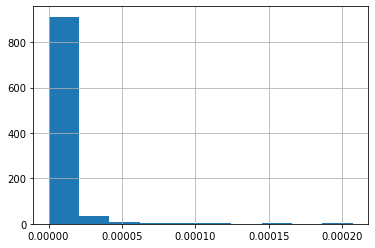

In [22]:
gdf_copy_0619[gdf_copy_0619['start_time_hour']>12]['OD_length'].hist()

In [23]:
df = gdf_copy_0619
for i in df.index:
    start_point = df.loc[i].geometry.coords[0]
    df.loc[i, 'start_latitude'] = start_point[1]
    df.loc[i, 'start_longitude'] = start_point[0]
    
    end_point = df.loc[i].geometry.coords[-1]
    df.loc[i, 'end_latitude'] = end_point[1]
    df.loc[i, 'end_longitude'] = end_point[0]
    
gdf_copy_0619 = df

In [24]:
keep_gdf_clean['starttime'] = keep_gdf_clean['start'] %(24*3600)
keep_gdf_clean['endtime'] = keep_gdf_clean['end'] %(24*3600)

Text(0, 0.5, 'Sample Density')

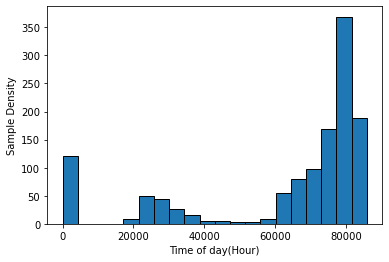

In [25]:
keep_gdf_clean.starttime.hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('Time of day(Hour)')
plt.ylabel('Sample Density')

Text(0, 0.5, 'Sample Density')

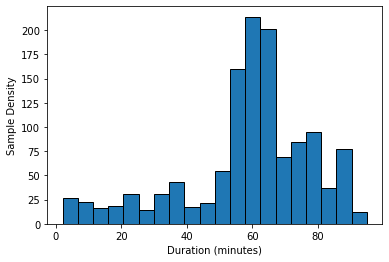

In [26]:
keep_gdf_clean.duration_minutes.hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('Duration (minutes)')
plt.ylabel('Sample Density')

In [27]:
keep_gdf_clean.duration_minutes.quantile(0.9),keep_gdf_clean.duration_minutes.quantile(0.1)

(82.40000000000009, 28.0)

### 对运动场集中跑步行为进行识别

In [28]:
keep_gdf_clean = keep_gdf_clean.reset_index()

In [29]:
grid_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [30]:
keep_gdf_clean.crs = 'epsg:4326'

In [31]:
def gridcreate(gdf):
    xmin, ymin, xmax, ymax = gdf.total_bounds

    length = 0.001
    wide = 0.001

    cols = list(np.arange(xmin, xmax + wide, wide))
    rows = list(np.arange(ymin, ymax + length, length))

    polygons = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

    return gpd.GeoDataFrame({'geometry':polygons})

In [32]:
for j in keep_gdf_clean.index:
    grid_copy = gridcreate(keep_gdf_clean[j:j+1])
    for i in grid_copy.index:
        lengthsum = 0
        clip = gpd.overlay(keep_gdf_clean[j:j+1], grid_copy[i:i+1], how='intersection')
        if len(clip)> 0 :
                for k in clip.index:
                    lengthsum = lengthsum + clip.loc[k,'geometry'].length
                grid_copy.loc[i,'lengthsum'] = lengthsum
    if j % 20 == 0:
        print(str(j) + '/' + str(len(keep_gdf_clean.index)))
    keep_gdf_clean.loc[j,'runtype_v'] = grid_copy['lengthsum'].mean()

0/1247
20/1247
40/1247
60/1247
80/1247
100/1247
120/1247
140/1247
160/1247
180/1247
200/1247
220/1247
240/1247
260/1247
280/1247
300/1247
320/1247
340/1247
360/1247
380/1247
400/1247
420/1247
440/1247
460/1247
480/1247
500/1247
520/1247
540/1247
560/1247
580/1247
600/1247
620/1247
640/1247
660/1247
680/1247
700/1247
720/1247
740/1247
760/1247
780/1247
800/1247
820/1247
840/1247
860/1247
880/1247
900/1247
920/1247
940/1247
960/1247
980/1247
1000/1247
1020/1247
1040/1247
1060/1247
1080/1247
1100/1247
1120/1247
1140/1247
1160/1247
1180/1247
1200/1247
1220/1247
1240/1247


Text(0, 0.5, 'Sample Density')

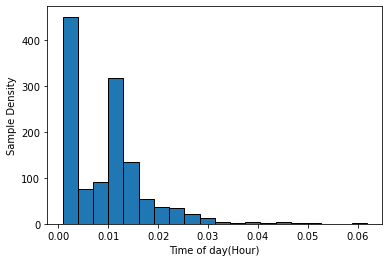

In [33]:
keep_gdf_clean['runtype_v'].hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('Time of day(Hour)')
plt.ylabel('Sample Density')

1247


<AxesSubplot:>

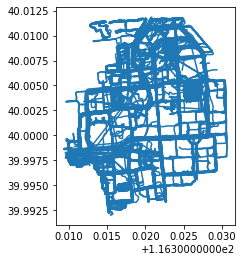

In [34]:
print(len(keep_gdf_clean))
keep_gdf_clean.plot()

180


<AxesSubplot:>

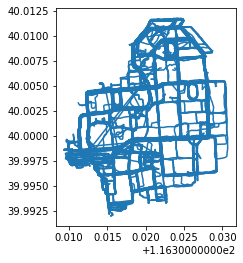

In [35]:
print(len(keep_gdf_clean[(keep_gdf_clean['runtype_v'] <= 0.002) & (keep_gdf_clean['runtype_v'] > 0.001)]))
keep_gdf_clean[(keep_gdf_clean['runtype_v'] <= 0.002) & (keep_gdf_clean['runtype_v'] > 0.001)].plot()

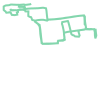

In [36]:
keep_gdf_clean[(keep_gdf_clean['runtype_v'] <= 0.002) & (keep_gdf_clean['runtype_v'] > 0.001)].geometry[1]

194


<AxesSubplot:>

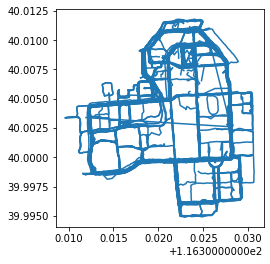

In [37]:
print(len(keep_gdf_clean[(keep_gdf_clean['runtype_v'] <= 0.001) & (keep_gdf_clean['runtype_v'] > 0.000)]))
keep_gdf_clean[(keep_gdf_clean['runtype_v'] <= 0.001) & (keep_gdf_clean['runtype_v'] > 0.000)].plot()

218


<AxesSubplot:>

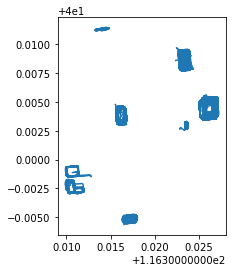

In [38]:
print(len(keep_gdf_clean[(keep_gdf_clean['runtype_v'] <= 1) & (keep_gdf_clean['runtype_v'] > 0.015)]))
keep_gdf_clean[(keep_gdf_clean['runtype_v'] <= 1) & (keep_gdf_clean['runtype_v'] > 0.015)].plot() # 约有经过15次重复点

<AxesSubplot:>

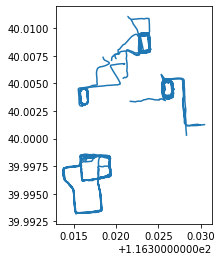

In [39]:
keep_gdf_clean[(keep_gdf_clean['runtype_v'] <= 0.005) & (keep_gdf_clean['runtype_v'] > 0.0045)].plot() # 约有经过15次重复点

<AxesSubplot:>

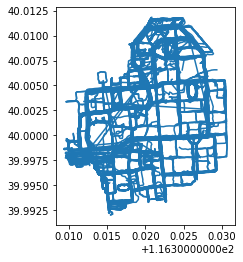

In [40]:
keep_gdf_clean[(keep_gdf_clean['runtype_v'] <= 0.003) & (keep_gdf_clean['runtype_v'] > 0.0005)].plot() # 约有经过15次重复点

429


<AxesSubplot:>

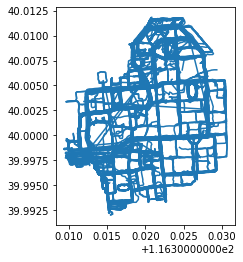

In [41]:
print(len(keep_gdf_clean[(keep_gdf_clean['runtype_v'] <= 0.003) & (keep_gdf_clean['runtype_v'] > 0.000)]))
keep_gdf_clean[(keep_gdf_clean['runtype_v'] <= 0.003) & (keep_gdf_clean['runtype_v'] > 0.000)].plot()

#### 草稿

In [42]:
grid_copy = gridcreate(keep_gdf_clean[0:1])
for i in grid_copy.index:
    lengthsum = 0
    clip = gpd.overlay(keep_gdf_clean[0:1], grid_copy[i:i+1], how='intersection')
    if len(clip)> 0 :
            for j in clip.index:
                lengthsum = lengthsum + clip.loc[j,'geometry'].length
            grid_copy.loc[i,'lengthsum'] = lengthsum
    else:
        pass

In [43]:
grid_copy.shape

(256, 2)

In [44]:
grid_copy['lengthsum'].describe()

count    66.000000
mean      0.000860
std       0.000375
min       0.000036
25%       0.000589
50%       0.001008
75%       0.001066
max       0.001715
Name: lengthsum, dtype: float64

In [45]:
grid_copy = gridcreate(keep_gdf_clean[10:11])
for i in grid_copy.index:
    lengthsum = 0
    clip = gpd.overlay(keep_gdf_clean[10:11], grid_copy[i:i+1], how='intersection')
    if len(clip)> 0 :
            for j in clip.index:
                lengthsum = lengthsum + clip.loc[j,'geometry'].length
            grid_copy.loc[i,'lengthsum'] = lengthsum
    else:
        pass

In [46]:
grid_copy['lengthsum'].describe()

count    4.000000
mean     0.019589
std      0.008259
min      0.009584
25%      0.014790
50%      0.020220
75%      0.025019
max      0.028332
Name: lengthsum, dtype: float64

In [47]:
grid_copy = gridcreate(keep_gdf_clean[18:19])
for i in grid_copy.index:
    lengthsum = 0
    clip = gpd.overlay(keep_gdf_clean[18:19], grid_copy[i:i+1], how='intersection')
    if len(clip)> 0 :
            for j in clip.index:
                lengthsum = lengthsum + clip.loc[j,'geometry'].length
            grid_copy.loc[i,'lengthsum'] = lengthsum
    else:
        pass

In [48]:
grid_copy['lengthsum'].describe()

count    4.000000
mean     0.013373
std      0.005054
min      0.007279
25%      0.010442
50%      0.013702
75%      0.016633
max      0.018810
Name: lengthsum, dtype: float64

### 描述性分析 跑步速度。5%-95%

In [49]:
startpt = keep_gdf_clean[(keep_gdf_clean['runtype_v'] <= 0.005) & (keep_gdf_clean['runtype_v'] > 0.000)][['start_longitude','start_latitude']].values
endpt = keep_gdf_clean[(keep_gdf_clean['runtype_v'] <= 0.005) & (keep_gdf_clean['runtype_v'] > 0.000)][['end_longitude','end_latitude']].values

In [50]:
starttime = keep_gdf_clean[(keep_gdf_clean['runtype_v'] <= 0.005) & (keep_gdf_clean['runtype_v'] > 0.000)]['starttime'].values
endtime =  keep_gdf_clean[(keep_gdf_clean['runtype_v'] <= 0.005) & (keep_gdf_clean['runtype_v'] > 0.000)]['endtime'].values

In [51]:
startpt_gdf = gpd.GeoDataFrame(startpt)
endpt_gdf = gpd.GeoDataFrame(endpt)

In [52]:
OD_gdf = gpd.GeoDataFrame()
OD_gdf.geometry = []
OD_gdf.crs = 'epsg:4326'

In [53]:
for i in range(0,len(startpt),1):
    OD_gdf.loc[i,'geometry'] = LineString([startpt[i],endpt[i]])

In [54]:
night_list=gdf_copy_0619[gdf_copy_0619['start_time_hour']>12].index.tolist()

In [55]:
keep_gdf_clean

,index,start_datetime,end_datetime,start,end,geometry,duration,start_latitude,start_longitude,end_latitude,...,duration_minutes,max_length,count_time,max_speed,starttime_hour,OD_length,start_time_hour,starttime,endtime,runtype_v
0,58,2022-05-16 21:51:10,2022-05-16 22:54:06,1461070,1464846,"LINESTRING (116.32259 39.99572, 116.32254 39.9...",0 days 01:02:56,39.995724,116.322593,39.996297,...,62.0,70.927441,153.0,175.030621,21.802222,1.337208e-05,21,78670,82446,0.000860
1,93,2022-05-16 09:06:06,2022-05-16 10:06:03,1415166,1418763,"LINESTRING (116.31371 39.99840, 116.31359 39.9...",0 days 00:59:57,39.998401,116.313713,39.997495,...,59.0,72.620140,184.0,226.476370,9.051111,6.364111e-06,9,32766,36363,0.001798
2,146,2022-05-16 21:48:09,2022-05-16 22:54:06,1460889,1464846,"LINESTRING (116.31893 40.00884, 116.31899 40.0...",0 days 01:05:57,40.008840,116.318930,40.007606,...,65.0,79.248435,215.0,262.129439,21.751944,6.653490e-06,21,78489,82446,0.000932
3,275,2022-05-16 22:51:05,2022-05-16 23:51:03,1464665,1468263,"LINESTRING (116.32346 40.00778, 116.32368 40.0...",0 days 00:59:58,40.007781,116.323460,40.008150,...,59.0,167.666334,239.0,679.190742,22.800833,4.156966e-07,22,82265,85863,0.012673
4,725,2022-05-16 21:48:09,2022-05-16 22:54:06,1460889,1464846,"LINESTRING (116.31617 40.00740, 116.31632 40.0...",0 days 01:05:57,40.007395,116.316166,40.006337,...,65.0,45.602389,283.0,198.545785,21.751944,1.695213e-06,21,78489,82446,0.007258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,158554,2022-05-22 22:40:06,2022-05-22 23:58:02,1982406,1987082,"LINESTRING (116.32909 40.00490, 116.32913 40.0...",0 days 01:17:56,40.004901,116.329087,39.999866,...,77.0,NaN,NaN,NaN,166.617778,3.176948e-05,22,81606,86282,0.001171
1243,158697,2022-05-22 22:40:06,2022-05-22 23:58:02,1982406,1987082,"LINESTRING (116.32289 40.00777, 116.32279 40.0...",0 days 01:17:56,40.007773,116.322891,40.007392,...,77.0,NaN,NaN,NaN,166.617778,2.120811e-07,22,81606,86282,0.000980
1244,158894,2022-05-22 20:32:10,2022-05-22 21:36:04,1974730,1978564,"LINESTRING (116.32538 40.00480, 116.32551 40.0...",0 days 01:03:54,40.004798,116.325376,40.004228,...,63.0,NaN,NaN,NaN,164.485556,3.350584e-07,20,73930,77764,0.020986
1245,159185,2022-05-22 07:24:08,2022-05-22 08:32:04,1927448,1931524,"LINESTRING (116.32105 39.99735, 116.32096 39.9...",0 days 01:07:56,39.997347,116.321047,39.997402,...,67.0,NaN,NaN,NaN,151.351667,6.563789e-05,7,26648,30724,0.001873


In [56]:
startpt_gdf

,0,1
0,116.322593,39.995724
1,116.313713,39.998401
2,116.318930,40.008840
3,116.320706,40.010967
4,116.320506,40.008037
...,...,...
470,116.312715,39.998562
471,116.329087,40.004901
472,116.322891,40.007773
473,116.321047,39.997347


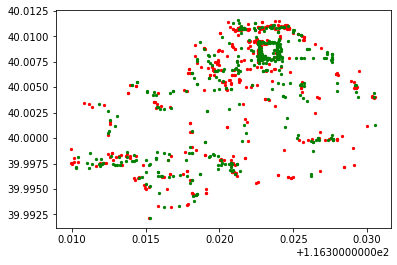

In [57]:
x = startpt_gdf[0]
y = startpt_gdf[1]
plt.scatter(x, y, color='red',s=5)

x = endpt_gdf[0]
y = endpt_gdf[1]
plt.scatter(x, y, color='g',s=5)

In [58]:
# ax = thu_gdf.plot(color = 'black', figsize = (12,12))
# ax = startpt_gdf.plot(color = 'r')
# endpt_gdf.plot(color = 'b')

### 加入时间维度

In [59]:
print(
    OD_gdf.geometry.shape,
    startpt.shape,
    endpt.shape,
    starttime.shape,
)

(475,) (475, 2) (475, 2) (475,)


In [60]:
start_list_lon = []
start_list_lat = []
for i in startpt:
    start_list_lon.append(i[0])
    start_list_lat.append(i[1])

In [61]:
end_list_lon = []
end_list_lat = []
for i in endpt:
    end_list_lon.append(i[0])
    end_list_lat.append(i[1])

In [62]:
start_gdf = pd.DataFrame(data = {'lon':start_list_lon,'lat':start_list_lat,'time':starttime})
end_gdf = pd.DataFrame(data = {'lon':end_list_lon,'lat':end_list_lat,'time':endtime})

In [63]:
start_gdf['timehour'] = start_gdf.time/3600
end_gdf['timehour'] = end_gdf.time/3600

In [64]:
start_list = start_gdf.drop(columns = ['time']).values
end_list = end_gdf.drop(columns = ['time']).values

In [65]:
print(start_list)
print(start_list.shape)
print(type(start_list[0][0]))
print(type(start_list[0][1]))
print(type(start_list[0][2]))

[[116.3225931893891 39.9957236106373 21.852777777777778]
 [116.31371315836373 39.998400508299426 9.101666666666667]
 [116.31892995619248 40.00884008240792 21.8025]
 ...
 [116.32289097679454 40.00777251226484 22.668333333333333]
 [116.32104654611287 39.99734651714061 7.402222222222222]
 [116.32037709126799 40.00520746278755 20.53611111111111]]
(475, 3)
<class 'float'>
<class 'float'>
<class 'float'>


In [66]:
x_plot = start_list_lon
y_plot = start_list_lat
z_plot = start_gdf.timehour

u_plot = (end_gdf.lon - start_gdf.lon).values
v_plot = (end_gdf.lat - start_gdf.lat).values
w_plot = (end_gdf.timehour - start_gdf.timehour).values

In [67]:
z_plot.max()

23.851111111111113

In [68]:
len(x_plot)

475

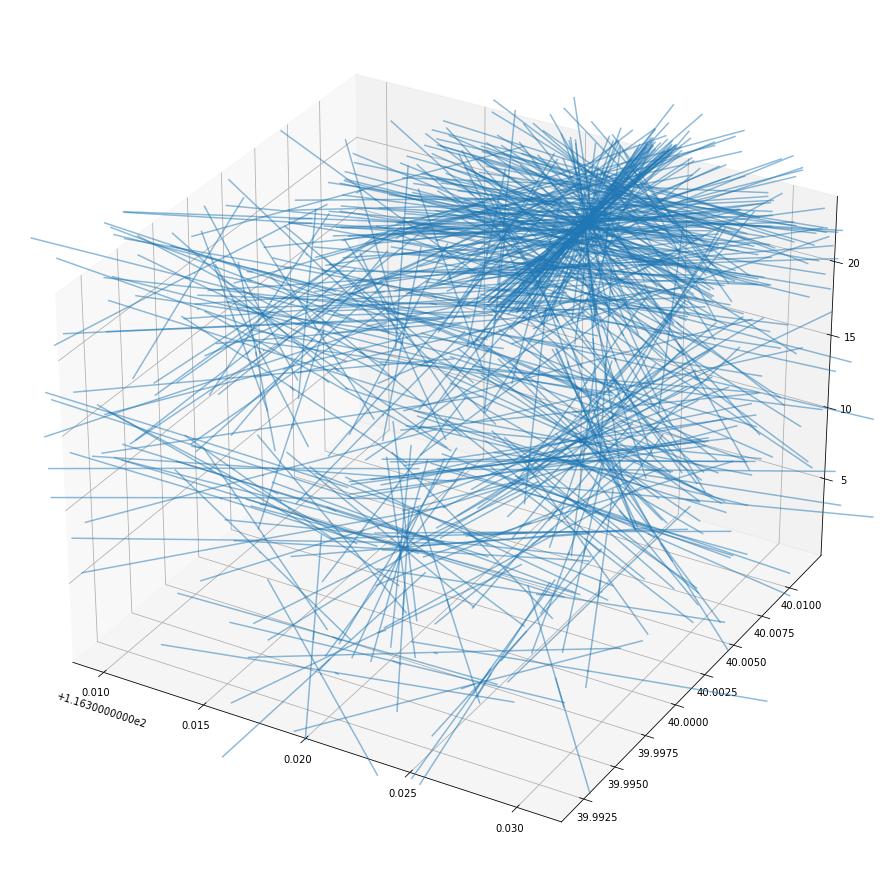

In [69]:
import matplotlib.pyplot as plt
import numpy as np

ax = plt.figure(figsize=(20,16)).add_subplot(projection='3d')

# # Make the grid
# x, y, z = np.meshgrid(np.arange(-0.8, 1, 0.2),
#                       np.arange(-0.8, 1, 0.2),
#                       np.arange(-0.8, 1, 0.8))

# # Make the direction data for the arrows
# u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
# v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
# w = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
#      np.sin(np.pi * z))

ax.quiver(x_plot, y_plot, z_plot, u_plot, v_plot, w_plot, length=0.1, normalize=True,alpha = 0.5)

plt.show()

### 清华路段分组

https://towardsdatascience.com/gps-trajectory-clustering-with-python-9b0d35660156#:~:text=GPS%20trajectory%20clustering%20with%20Python%201%20Trajectory%20data,Results%20and%20Trajectory%20visualization.%20...%205%20Conclusions.%20

In [70]:
def rdp_with_index(points, indices, epsilon):
    """rdp with returned point indices
    """
    dmax, index = 0.0, 0
    for i in range(1, len(points) - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > dmax:
            dmax, index = d, i
    if dmax >= epsilon:
        first_points, first_indices = rdp_with_index(points[:index+1], indices[:index+1], epsilon)
        second_points, second_indices = rdp_with_index(points[index:], indices[index:], epsilon)
        results = first_points[:-1] + second_points
        results_indices = first_indices[:-1] + second_indices
    else:
        results, results_indices = [points[0], points[-1]], [indices[0], indices[-1]]
    return results, results_indices

In [71]:
keep_gdf_clean.head(1)

,index,start_datetime,end_datetime,start,end,geometry,duration,start_latitude,start_longitude,end_latitude,...,duration_minutes,max_length,count_time,max_speed,starttime_hour,OD_length,start_time_hour,starttime,endtime,runtype_v
0,58,2022-05-16 21:51:10,2022-05-16 22:54:06,1461070,1464846,"LINESTRING (116.32259 39.99572, 116.32254 39.9...",0 days 01:02:56,39.995724,116.322593,39.996297,...,62.0,70.927441,153.0,175.030621,21.802222,0.000013,21,78670,82446,0.00086


In [72]:
keep_gdf_clean.shape

(1247, 21)

In [73]:
keep_gdf_clean['points'] = keep_gdf_clean.apply(lambda x: [y for y in x['geometry'].coords], axis=1)

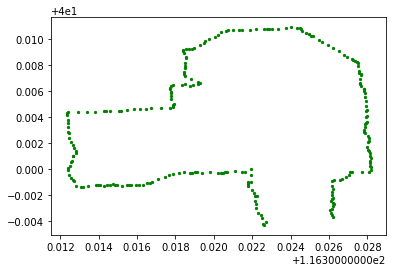

In [74]:
x = []
y = []
for i in keep_gdf_clean['points'][0]:
    x.append(i[0])
    y.append(i[1])
plt.scatter(x, y, color='g',s=5)

# output

In [75]:
outputlist = []
for i in keep_gdf_clean.index:
    outputlist.append(np.array(keep_gdf_clean['points'][i]))

In [76]:
# clean 
def pair(list):
        for i in range(1, len(list)):
            yield list[i-1],list[i]

def path_clean(df_clean,speedlimit):
    
    df_clean_copy = df_clean.to_crs('epsg:4509')

    max_list = []
    df_count = 0
    for i in df_clean_copy.geometry:
        test_list = list(i.coords)
        a_float = []
        k = 0
        for pt1,pt2 in pair(test_list):
            a_float.append(LineString([pt1,pt2]).length)
            k = k + 1
        df_clean_copy.loc[df_count,'max_length'] = max(a_float)
        df_clean_copy.loc[df_count,'count_time'] = k
        max_list.append(max(a_float))
        df_count = df_count + 1
    df_clean_copy['max_speed'] = df_clean_copy['max_length'] * df_clean_copy['count_time'] / df_clean_copy['duration_minutes']

    df_clean_copy_clear = df_clean_copy.drop(df_clean_copy[df_clean_copy['max_speed']>speedlimit].index)
    df_clean_clear = df_clean_copy_clear.to_crs('epsg:4509')

    keep_gdf_clean = df_clean_copy_clear.to_crs('epsg:4326')
    
    return keep_gdf_clean

In [1]:
def addinfo(df):

    for i in df.index:
        start_point = df.loc[i].geometry.coords[0]
        df.loc[i, 'start_latitude'] = start_point[1]
        df.loc[i, 'start_longitude'] = start_point[0]

        end_point = df.loc[i].geometry.coords[-1]
        df.loc[i, 'end_latitude'] = end_point[1]
        df.loc[i, 'end_longitude'] = end_point[0]

    # crs change
    df.crs = 'epsg:4326'
    df_copy = df.to_crs('epsg:4509')
    df_copy.length.head()

    df['start_date'] = df['start_time'].str.split('_').str[0]
    df['start_time_time'] = df['start_time'].str[3:].str.replace('_',":")

    df['end_date'] = df['end_time'].str.split('_').str[0]
    df['end_time_time'] = df['end_time'].str[3:].str.replace('_',":")

    df['start_date'] = '2022/05/'+df['start_date']
    df['end_date'] = '2022/05/'+df['end_date']

    df['start_datetime'] = pd.to_datetime(df['start_date'] + ' ' + df['start_time_time'])
    df['end_datetime'] = pd.to_datetime(df['end_date'] + ' ' + df['end_time_time'])

    df['duration'] = df['end_datetime']-df['start_datetime']


    df = df[['start_datetime', 'end_datetime', 'start', 'end', 'geometry', 'duration',
             'start_latitude','start_longitude','end_latitude','end_longitude']]


    df['duration_minutes'] = df.index.map(lambda i: divmod(df['duration'][i].total_seconds(), 60)[0] )
    
    return df

In [78]:
keep_copy = path_clean(keep_gdf_clean,560)

In [79]:
keep_copy.shape

(1094, 22)

<AxesSubplot:>

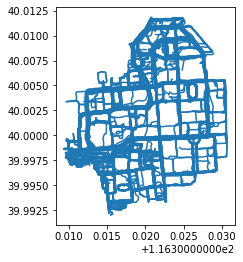

In [80]:
keep_copy[(keep_copy['runtype_v'] <= 0.003) & (keep_copy['runtype_v'] > 0.000)].plot()

In [81]:
keep_copy['duration']

0      0 days 01:02:56
1      0 days 00:59:57
2      0 days 01:05:57
3      0 days 00:59:58
4      0 days 01:05:57
             ...      
1242   0 days 01:17:56
1243   0 days 01:17:56
1244   0 days 01:03:54
1245   0 days 01:07:56
1246   0 days 01:03:54
Name: duration, Length: 1094, dtype: timedelta64[ns]

In [82]:
keep_copy[['geometry','runtype_v','duration_minutes']].to_file("data.json", driver='GeoJSON', encoding="utf-8")

# model

这里已经用其他的模型算过了，导入结果cluster_lst

In [83]:
cluster_df = pd.read_csv('../03_data/cluster.csv')

In [84]:
cluster_lst = cluster_df['0'].values

In [85]:
keep_copy['pathtype'] = cluster_lst

<AxesSubplot:>

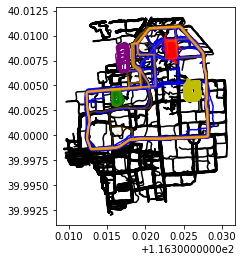

In [86]:
ax = keep_copy[keep_copy.pathtype == -1].plot(color = 'black')
keep_copy[keep_copy.pathtype == 0].plot(ax=ax,color = 'b')
keep_copy[keep_copy.pathtype == 1].plot(ax=ax,color = 'r')
keep_copy[keep_copy.pathtype == 2].plot(ax=ax,color = 'y')
keep_copy[keep_copy.pathtype == 3].plot(ax=ax,color = 'g')
keep_copy[keep_copy.pathtype == 4].plot(ax=ax,color = 'purple')
keep_copy[keep_copy.pathtype == 5].plot(ax=ax,color = 'orange',alpha = 0.2)

纳入统计中的路径有658/1094即0.6014625228519196


Text(0, 0.5, 'Sample Density')

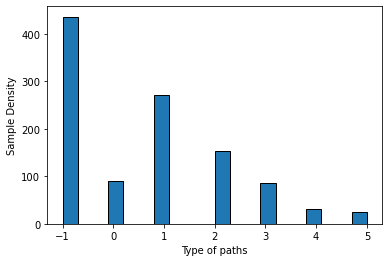

In [87]:
print('纳入统计中的路径有' 
      + str(len(keep_copy) - len(keep_copy[keep_copy.pathtype == -1])) 
      + '/' 
      + str(len(keep_copy)) 
      + '即' 
      + str((len(keep_copy) - len(keep_copy[keep_copy.pathtype == -1]))/len(keep_copy))
     )
keep_copy.pathtype.hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('Type of paths')
plt.ylabel('Sample Density')

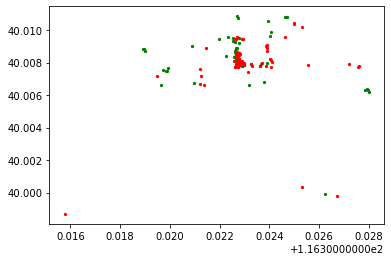

In [88]:
plt.scatter(keep_copy[keep_copy.pathtype == 0]['start_longitude'],keep_copy[keep_copy.pathtype == 0]['start_latitude'], color='g',s=5)
plt.scatter(keep_copy[keep_copy.pathtype == 0]['end_longitude'],keep_copy[keep_copy.pathtype == 0]['end_latitude'], color='r',s=5)


Text(0, 0.5, 'CampusRun Sample Density')

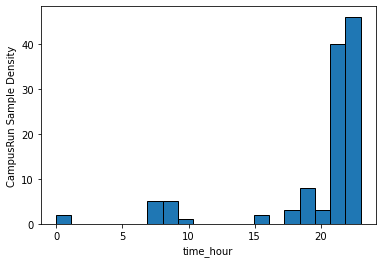

In [89]:
keep_copy[(keep_copy.pathtype == 0) | (keep_copy.pathtype == 5)].start_time_hour.hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('time_hour')
plt.ylabel('CampusRun Sample Density')

Text(0, 0.5, 'Court Sample Density')

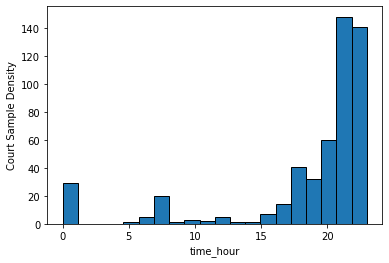

In [90]:
keep_copy[(keep_copy.pathtype == 1) | (keep_copy.pathtype == 2) | (keep_copy.pathtype == 3)].start_time_hour.hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('time_hour')
plt.ylabel('Court Sample Density')

# 时间序列和环境变量情况

In [91]:
sjoin_intersects.columns

Index(['start_time', 'end_time', 'start', 'end', 'geometry', 'index_right',
       'fid', 'osm_id', 'osm_way_id', 'name', 'type', 'aeroway', 'amenity',
       'admin_leve', 'barrier', 'boundary', 'building', 'craft', 'geological',
       'historic', 'land_area', 'landuse', 'leisure', 'man_made', 'military',
       'natural', 'office', 'place', 'shop', 'sport', 'tourism', 'other_tags',
       'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude',
       'start_date', 'start_time_time', 'end_date', 'end_time_time',
       'start_datetime', 'end_datetime', 'duration'],
      dtype='object')

# 其他

空间一致，时间一致中 研究个体差异

In [92]:
sjoin_intersects['starttime_hour'] = (sjoin_intersects.start - sjoin_intersects.start.min()) / 3600

In [93]:
gdf_0425_0 = sjoin_intersects[sjoin_intersects.starttime_hour <= 8.950278]

In [94]:
gdf_0425_1 = sjoin_intersects[(sjoin_intersects.starttime_hour > 8.950278) 
                              & (sjoin_intersects.starttime_hour <= 19.300556)]

In [95]:
gdf_0425_2 = sjoin_intersects[(sjoin_intersects.starttime_hour > 19.300556) 
                              & (sjoin_intersects.starttime_hour <= 21.251667)]

In [96]:
gdf_0425_3 = sjoin_intersects[(sjoin_intersects.starttime_hour > 21.251667) 
                              & (sjoin_intersects.starttime_hour <= 23.799722)]

<AxesSubplot:>

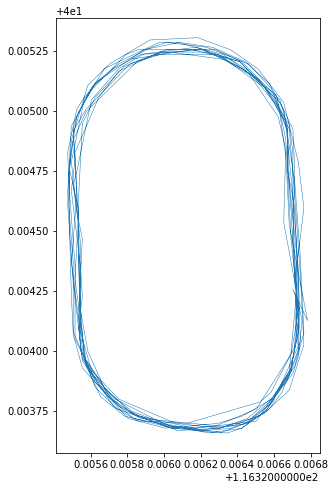

In [97]:
gdf_0425_3[17:18].plot(figsize = (12,8),linewidth = 0.5)

<AxesSubplot:>

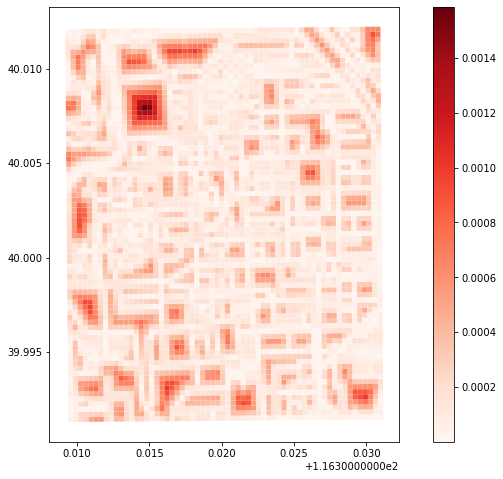

In [98]:
from palettable.colorbrewer.sequential import Reds_9 
grid_gdf.fillna(0).plot(column = 'roaddist',figsize = (12,8),legend=True, cmap=Reds_9.mpl_colormap)

<AxesSubplot:>

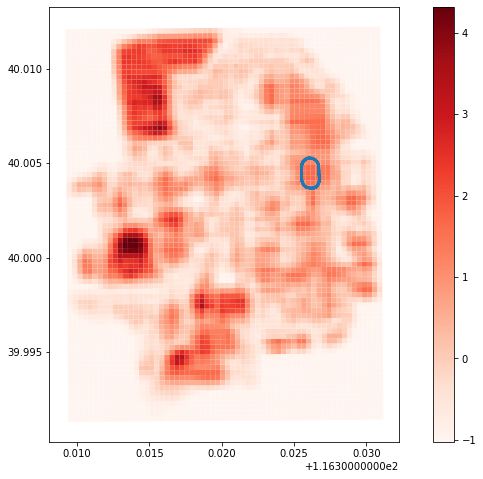

In [99]:
grid_gdf.crs = 'epsg:4326'
ax = grid_gdf.fillna(0).plot(column = 'OSM_area',figsize = (12,8),legend=True, cmap=Reds_9.mpl_colormap)
gdf_0425_3[17:18].plot(ax=ax , figsize = (12,8),linewidth = 2)

In [101]:
## 雷达图 

<AxesSubplot:>

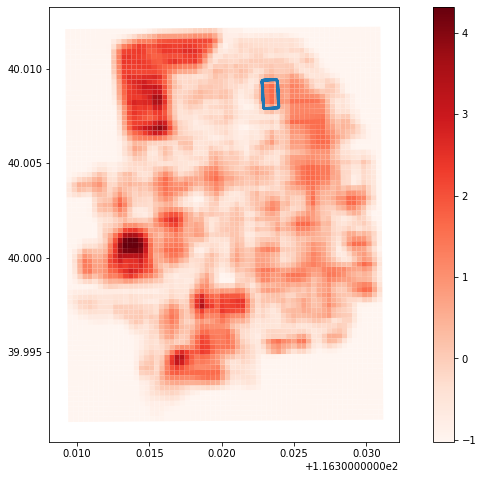

In [102]:
grid_gdf.crs = 'epsg:4326'
ax = grid_gdf.fillna(0).plot(column = 'OSM_area',figsize = (12,8),legend=True, cmap=Reds_9.mpl_colormap)
gdf_0425_3[23:24].plot(ax=ax , figsize = (12,8),linewidth = 2)

In [103]:
gdf_4509 = gdf_0425_3.to_crs('epsg:4509')

In [104]:
gdf_4509.shape

(46, 44)

In [ ]:
gdf_4509.loc[58,'geometry'].plot()

In [ ]:
stop

In [105]:
# 根据GPS定位次数创建路段文件，计算并赋予速度属性
test_list = list(gdf_4509.loc[58,'geometry'].coords)
a_gdf = gpd.GeoDataFrame(data = None, columns = ['derive','length','duration','speed','geometry'])
a_gdf.crs = 'epsg:4509'
k = 0
for pt1,pt2 in pair(test_list):
    a_gdf.loc[k,'derive'] = k
    a_gdf.loc[k,'length'] = LineString([pt1,pt2]).length
    a_gdf.loc[k,'duration'] = (gdf_4509.loc[58,'end'] - gdf_4509.loc[58,'start']) / len(test_list)
    a_gdf.loc[k,'speed'] = a_gdf.loc[k,'length'] / a_gdf.loc[k,'duration']
    a_gdf.loc[k,'geometry'] = LineString([pt1,pt2])
    if k == 0:
        a_gdf.loc[k,'start'] = gdf_4509.loc[58,'start']
        a_gdf.loc[k,'end'] = gdf_4509.loc[58,'start'] + a_gdf.loc[k,'duration']
    else:
        a_gdf.loc[k,'start'] = a_gdf.loc[k-1,'end']
        a_gdf.loc[k,'end'] = a_gdf.loc[k-1,'end'] + a_gdf.loc[k,'duration']
    k = k + 1

In [106]:
a = a_gdf.values
print(np.shape(a))

(243, 7)


In [107]:
gdf_4509.loc[58,'end'] - gdf_4509.loc[58,'start']

3776

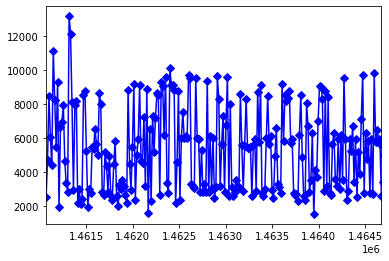

In [108]:
y1 = a[:,3]*3600 # 米每小时
x = a[:,5]
ax = plt.subplot(111)
ax.set_xlim(gdf_4509.loc[58,'start'],gdf_4509.loc[58,'start']+3600)
plotdict = {'dx':x,"dy":y1}
ax.plot('dx','dy','bD-',data=plotdict)

In [109]:
c = a
b = c

In [110]:
for i in range(0,len(c)-1,1):
    b[i,3] = c[np.max([0,i-10]):np.min([len(c)-1,i+11]),3].mean()

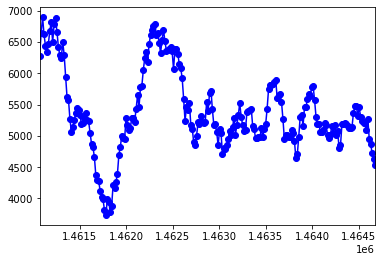

In [111]:
y1 = b[:,3]*3600 # 米每小时
x = b[:,5]
ax = plt.subplot(111)
ax.set_xlim(gdf_4509.loc[58,'start'],gdf_4509.loc[58,'start']+3600)
plotdict = {'dx':x,"dy":y1}
ax.plot('dx','dy','bo-',data=plotdict)

<AxesSubplot:>

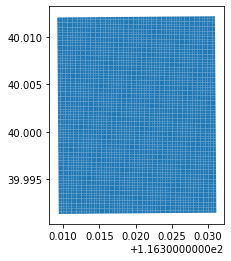

In [112]:
grid_gdf.plot()

<AxesSubplot:>

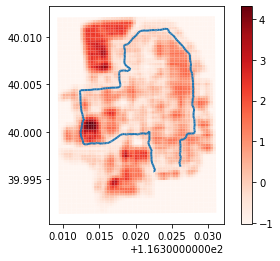

In [113]:
a_gdf = a_gdf.to_crs('epsg:4326')
grid_gdf.crs = 'epsg:4326'
ax = grid_gdf.fillna(0).plot(column = 'OSM_area',legend=True, cmap=Reds_9.mpl_colormap)
a_gdf.plot(ax=ax , figsize = (12,8),linewidth = 2)

In [114]:
# 将路段文件与网格做交集 注意！这个要算约1300*2136次，我的Mac要做三个小时！

a_gdf = a_gdf.to_crs('epsg:4509')
grid_gdf = grid_gdf.to_crs('epsg:4509')

for x in a_gdf.index:
    hull = gpd.GeoDataFrame(geometry=a_gdf.geometry[x:x+1].buffer(15))
    hull['dissolve'] = 1
    hull = hull.dissolve(by='dissolve')
    OSM_hull = gpd.sjoin(grid_gdf, hull)
    a_gdf.loc[x,'natural_ar'] = OSM_hull.natural_ar.mean(axis = 0)
    a_gdf.loc[x,'OSM_area'] = OSM_hull.OSM_area.mean(axis = 0)

In [115]:
a_gdf = a_gdf.fillna(0)
a_gdf.head()

,derive,length,duration,speed,geometry,start,end,natural_ar,OSM_area
0,0,10.873531,15.47541,0.702633,"LINESTRING (442149.774 4429274.010, 442145.589...",1.461070e+06,1.461085e+06,-0.202681,-0.418416
1,1,20.422669,15.47541,1.319685,"LINESTRING (442145.589 4429284.046, 442160.182...",1.461085e+06,1.461101e+06,-0.202681,-0.546588
2,2,36.470461,15.47541,2.356672,"LINESTRING (442160.182 4429298.334, 442143.383...",1.461101e+06,1.461116e+06,-0.202681,-0.530084
3,3,26.240257,15.47541,1.695610,"LINESTRING (442143.383 4429330.705, 442137.610...",1.461116e+06,1.461132e+06,-0.202681,-0.487575
4,4,19.111003,15.47541,1.234927,"LINESTRING (442137.610 4429356.303, 442126.651...",1.461132e+06,1.461147e+06,-0.202681,-0.450117


In [116]:
a = a_gdf.values
print(np.shape(a))

(243, 9)


In [117]:
gdf_4509.loc[58,'end'] - gdf_4509.loc[58,'start']

3776

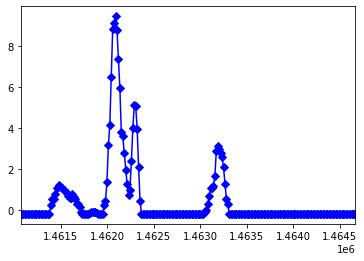

In [118]:
y1 = a[:,7]
x = a[:,5]
ax = plt.subplot(111)
ax.set_xlim(gdf_4509.loc[58,'start'],gdf_4509.loc[58,'start']+3600)
plotdict = {'dx':x,"dy":y1}
ax.plot('dx','dy','bD-',data=plotdict)

In [119]:
b = a
for i in range(0,len(a)-1,1):
    a[i,3] = b[np.max([0,i-10]):np.min([len(a)-1,i+11]),3].mean()

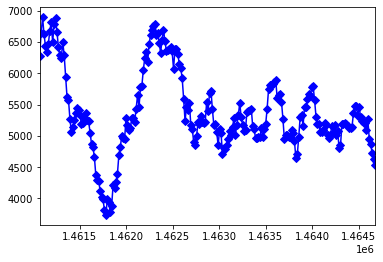

In [120]:
y1 = a[:,3]*3600 # 米每小时
x = a[:,5]
ax = plt.subplot(111)
ax.set_xlim(gdf_4509.loc[58,'start'],gdf_4509.loc[58,'start']+3600)
plotdict = {'dx':x,"dy":y1}
ax.plot('dx','dy','bD-',data=plotdict)

In [121]:
# 双坐标轴图
import plotly as py 
import plotly.graph_objs as go

In [125]:
pyplt = py.offline.plot

trace1 = go.Scatter(
    x = a[:,5],
    y = a[:,3]*3600,
    name='Speed',
    xaxis='x',
    yaxis='y1'
)
trace2 = go.Scatter(
    x = a[:,5],
    y = a[:,7],
    name='nature',
    xaxis='x',
    yaxis='y2'
)
trace3 = go.Scatter(
    x = a[:,5],
    y = a[:,8],
    name='OSM',
    xaxis='x',
    yaxis='y3'
)

data = [trace1,trace2,trace3]
layout = go.Layout(
    title = 'speed与nature字段关联',
    yaxis = dict(
        title='speed'
    ),
    yaxis2 = dict(
        title = 'natural_area',
        titlefont = dict(
            color = 'rgb(148, 103, 189)'
        ),
        tickfont = dict(
            color = 'rgb(148, 103, 189)'
        ),
        overlaying = 'y',
        side = 'right'
    ),
    yaxis3 = dict(
        title = 'OSM_area',
        titlefont = dict(
            color = 'rgb(148, 103, 189)'
        ),
        tickfont = dict(
            color = 'rgb(148, 103, 189)'
        ),
        overlaying = 'y',
        side = 'right'
    )
)
fig = go.Figure(data=data, layout=layout)
plot_url = pyplt(fig, filename='multi_yaxis.html')